<a href="https://colab.research.google.com/github/amirrezafahimi/end_to_end_classification_MNIST_dataset/blob/main/end_to_end_classification_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Package Imports

In [ ]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

from sklearn.base import clone, BaseEstimator
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve, roc_curve
from sklearn.metrics import plot_roc_curve as plt_roc_curve
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.neighbors import KNeighborsClassifier

from scipy.ndimage.interpolation import shift

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [2]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [3]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
mnist["data"], mnist["target"]

In [4]:
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [5]:
X, y = mnist.data, mnist.target

In [6]:
X.shape, y.shape

((70000, 784), (70000,))

In [7]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size, size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

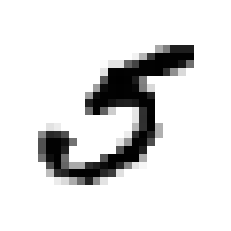

In [8]:
some_data = X[36000]
plt.imshow(some_data.reshape((28, 28)), cmap=plt.get_cmap("binary"), 
          interpolation="nearest")
plt.axis("off")
plt.show()

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [10]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 784), (60000,), (10000, 784), (10000,))

In [11]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [12]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [13]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [14]:
sgd_clf.predict([some_data])

array([ True])

## Measuring Accuracy Using Cross-Validation

In [15]:
skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_folds = X_train[test_index]
    y_test_folds = (y_train_5[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.9613
0.9635
0.9661


In [16]:
cross_val_score(sgd_clf, X_train, y=y_train_5, cv=3, scoring="accuracy")

array([0.9613, 0.9635, 0.9661])

If we take the mean of the above scores, we get 96% accuracy! is that great? should we end this here? well... NO! our model only predicts if the number is 5 or not, and 5 only consists of 10% of our data. If we create a model that classifies all numbers as non 5, then we should get a 90% accuracy. Let's just create that model and expand the discussion. 

In [17]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros(shape=(len(X), 1), dtype=bool)

In [18]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.909  , 0.90715, 0.9128 ])

Our model wasn't that great huh?😒 even a stupid model that does nothing has the accuracy of 90%. This is simply because only about 10% of the images are 5s, so if you always guess that an image is not a 5, you will be right about 90% of the time. Beats Nostradamus.

## Confusion Matrix

A much better way to evaluate the performance of a classifier is to look at the confusion matrix. The general idea is to count the number of times instances of class A are classified as class B. For example, to know the number of times the classifier confused images of 5s with 3s, you would look in the 5th row and 3rd column of the confusion matrix.

In [19]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [20]:
confusion_matrix(y_train_5, y_train_pred)

array([[54122,   457],
       [ 1725,  3696]])

Each row in a confusion matrix represents an actual class, while each column represents a predicted class. The first row of this matrix considers non-5 images (the negative class): 54,122 of them were correctly classified as non-5s (they are called true negatives), while the remaining 457 were wrongly classified as 5s (false positives). The second row considers the images of 5s (the positive class): 1,725 were wrongly classified as non-5s (false negatives), while the remaining 3,696 were correctly classified as 5s (true positives). A perfect classifier would have only true positives and true negatives, so its confusion matrix would have nonzero values only on its main diagonal (top left to bottom right)

In [21]:
confusion_matrix(y_train_5, y_train_5)

array([[54579,     0],
       [    0,  5421]])

## Precision and Recall

The confusion matrix gives you a lot of information, but sometimes you may prefer a more concise metric. An interesting one to look at is the accuracy of the positive predictions; this is called the precision of the classifier. The formula for prediction is: $$TP \div (TP + FP)$$

precision is typically used along with another metric named recall, also called sensitivity or true positive rate: The formula for recall is: 
$$TP \div (TP + FN)$$


In [22]:
print(f"The precision is: {precision_score(y_train_5, y_train_pred)}")
print(f"The recall is: {recall_score(y_train_5, y_train_pred)}")

The precision is: 0.8899590657356128
The recall is: 0.6817930271167681


If you need a simple way to compare two models precision and recall, you can use the F1 score. The formula for F score is: 
$$ 2 \times (precision \times recall) \div (precision + recall)$$

F1-socre usually works for models that have the same precision and recall, take this into consideration that sometimes you only care about precision or recall alone. 

In [23]:
print(f"The F1-score is: {f1_score(y_train_5, y_train_pred)}")

The F1-score is: 0.7720910800083559


To understand this tradeoff, let’s look at how the `SGDClassifier` makes its classification decisions. For each instance, it computes a score based on a decision function, and if that score is greater than a threshold, it assigns the instance to the positive class, or else it assigns it to the negative class. 

In [24]:
y_scores = sgd_clf.decision_function([some_data])
y_scores

array([5220.50278623])

In [25]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [26]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [27]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [28]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Let's plot precision and recall as function of threshold

In [29]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

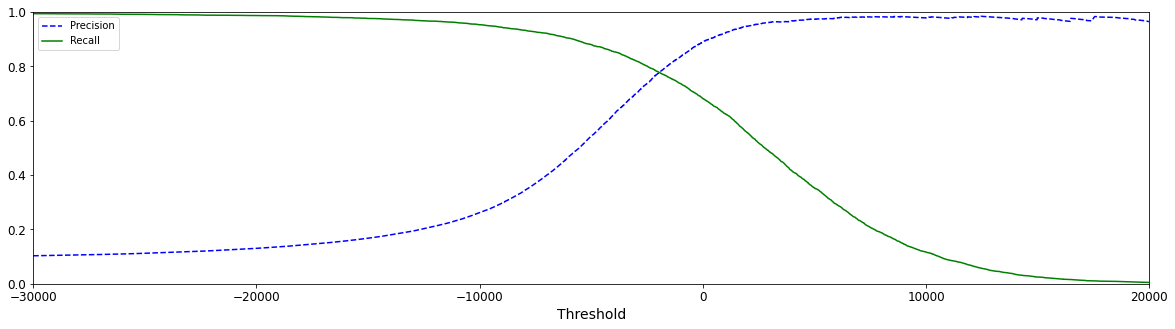

In [30]:
plt.figure(figsize=(20, 5))
plt.xlim((-30000, 20000))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Now you can simply select the threshold value that gives you the best precision/recall tradeoff for your task. Another way to select a good precision/recall tradeoff is to plot precision directly against recall

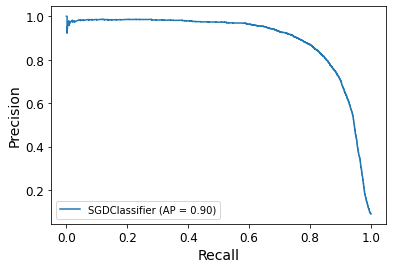

In [31]:
plot_precision_recall_curve(sgd_clf, X_train, y_train_5)
plt.show()

So let’s suppose you decide to aim for 90% precision. You look up the first plot (zooming in a bit) and find that you need to use a threshold of about 300.

In [32]:
y_train_pred_90 = (y_scores > 300)

In [33]:
print(f"The precision is: {precision_score(y_train_5, y_train_pred_90)}")
print(f"The recall is: {recall_score(y_train_5, y_train_pred_90)}")

The precision is: 0.9009728111748566
The recall is: 0.6662977310459325


## The ROC Curve

In [34]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [35]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

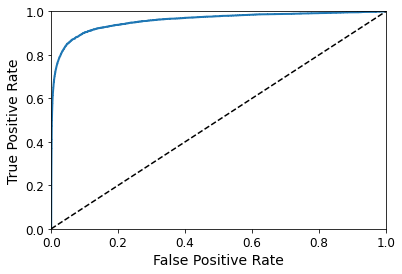

In [36]:
plot_roc_curve(fpr, tpr)
plt.show()

You can use `plot_roc_curve` from sklearn package to plot the ROC curve

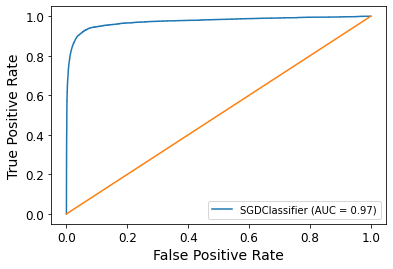

In [37]:
plt_roc_curve(sgd_clf, X_train, y_train_5)
plt.plot([0, 1], [0, 1])
plt.show()

One way to compare two models is to calculate the area under the curve of ROC. we use sklearn's `roc_auc_score`.

In [38]:
roc_auc_score(y_train_5, y_scores)

0.9577210519742373

Let's create a `RandomForestClassifier` and compare it's ROC AUC to `SGDClassifier`

In [39]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                   method="predict_proba")

In [40]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)

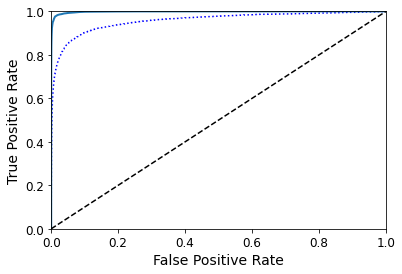

In [41]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, label="Random Forest")
# plt.legend("bottom right")
plt.show()

As you can see, the ROC AUC score for `RandomForestClassifier` is bigger than `SGDClassifier` which means that it performs better.

In [42]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983730844244434

## Multiclass Classification

Let's try to fit `SGDClassifier` to all of our dataset

In [43]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [44]:
sgd_clf.predict([some_data])

array([5], dtype=int8)

In [45]:
some_digit_scores = sgd_clf.decision_function([some_data])
some_digit_scores

array([[ -8204.47519778, -19206.28224706,  -5702.10113982,
         -4666.3653033 , -15827.7809826 ,   1782.52380291,
        -39807.3747045 , -18945.8333413 , -14650.34384565,
        -16166.06981109]])

In [46]:
np.argmax(some_digit_scores)
sgd_clf.classes_[np.argmax(some_digit_scores)]

5

Let's create a `OneVsOneClassifier`

In [47]:
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_data])

array([5], dtype=int8)

In [48]:
len(ovo_clf.estimators_)

45

In [49]:
forest_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [50]:
forest_clf.predict([some_data])

array([5], dtype=int8)

In [51]:
forest_clf.predict_proba([some_data])

array([[0.06, 0.  , 0.01, 0.07, 0.  , 0.86, 0.  , 0.  , 0.  , 0.  ]])

In [52]:
cross_val_score(forest_clf, X_train, y_train, scoring="accuracy", cv=3)

array([0.9655, 0.9661, 0.9664])

That's good, but can we make it better by standerdizing the inputs? Let's try

In [53]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(forest_clf, X_train_scaled, y_train, scoring="accuracy", cv=3)

array([0.9657 , 0.9661 , 0.96635])

Well, that was a great waste of time😎

Let's skip all those model selections, fine tuning them and ... to get to the, 

## Error Analysis

In [54]:
y_train_pred = sgd_clf.predict(X_train)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5706,    1,   27,   23,   14,   17,   59,    1,   46,   29],
       [   1, 6546,   28,   37,   17,    5,   15,    8,   71,   14],
       [  18,   51, 5025,  234,  126,   24,  143,   89,  224,   24],
       [  16,   20,  102, 5675,   38,   70,   36,   39,   60,   75],
       [   8,   15,    9,   14, 5600,    1,   24,   11,   54,  106],
       [  33,   25,   28,  880,  253, 3512,  331,    8,  210,  141],
       [  20,   10,   32,    1,   62,   26, 5737,    3,   24,    3],
       [  18,   15,   23,   27,   86,   12,    6, 5727,   41,  310],
       [  26,   78,   75,  503,  216,   78,   96,   14, 4588,  177],
       [  17,   23,   11,  170,  358,   30,    2,  166,   49, 5123]])

This is alot of number, let's visualize this for better interpretation

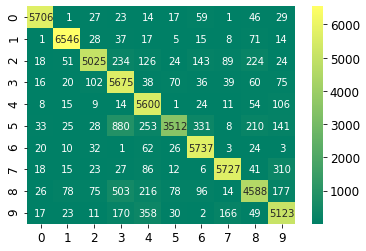

In [55]:
sns.heatmap(data=conf_mx, annot=True, fmt="2", cmap=plt.cm.summer)

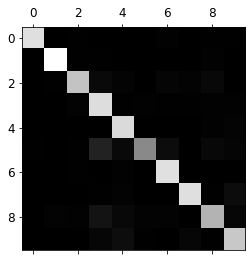

In [56]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

In [57]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

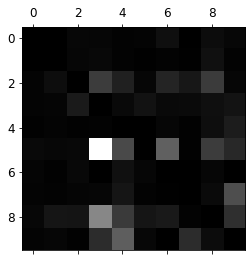

In [58]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

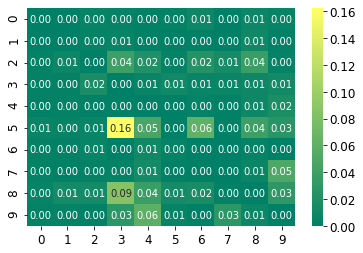

In [59]:
sns.heatmap(data=norm_conf_mx, cmap=plt.cm.summer, annot=True, fmt=".2f")
plt.show()

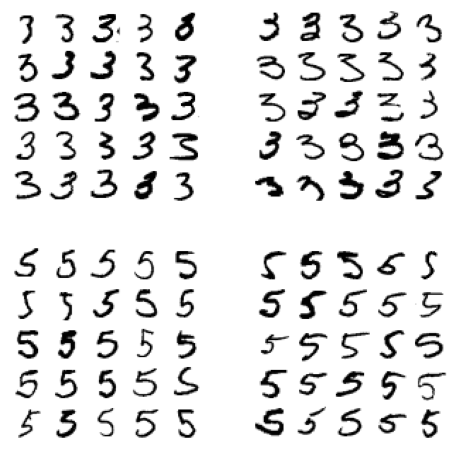

In [60]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

## Multiclass Classification

In [61]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [63]:
knn_clf = KNeighborsClassifier(n_jobs=-1)
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

In [64]:
knn_clf.predict([some_data])

array([[False,  True]])

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="marco")

## Multioutput Classification

Let’s start by creating the training and test sets by taking the MNIST images and adding noise to their pixel intensities using NumPy’s `randint()` function. The target images will be the original images

In [69]:
noise = np.random.randint(0, 100, size=(len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, size=(len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

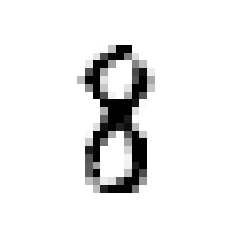

In [72]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_train_mode[5]])
plot_digits(clean_digit)

## KNN Classifier

In [73]:
knn_clf = KNeighborsClassifier(n_jobs=-1, weights="distance", n_neighbors=4)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
                     weights='distance')

In [ ]:
y_knn_pred = knn_clf.predict(X_test)

In [ ]:
accuracy_score(y_test, y_knn_pred)

In [ ]:
def shift_digit(digit_array, dx, dy, new=0):
  return shift(digit_array.reshape(28, 28), [dy, dx], cval=new).reshape(784)

plot_digits(shift_digit(some_data, 5, 1, new=100))

In [ ]:
X_train_expanded = [X_train]
y_train_expanded = [y_train]
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    shifted_images = np.apply_along_axis(shift_digit, axis=1, arr=X_train, dx=dx, dy=dy)
    X_train_expanded.append(shifted_images)
    y_train_expanded.append(y_train)

X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)
X_train_expanded.shape, y_train_expanded.shape

In [ ]:
knn_clf.fit(X_train_expanded, y_train_expanded)

In [ ]:
y_knn_expanded_pred = knn_clf.predict(X_test)

In [ ]:
accuracy_score(y_test, y_knn_expanded_pred)

In [ ]:
ambiguous_digit = X_test[2589]
knn_clf.predict_proba([ambiguous_digit])

In [ ]:
plot_digit(ambiguous_digit)

## An MNIST Classifier with Over 97% Accuracy

In [ ]:
param_grid = [{
    "weights": ["uniform", "distance"], 
    "n_neighbors": [3, 4, 5]
}]

knn_clf = KNeighborClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_score_

In [ ]:
y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)